In [1]:
import numpy as np
from scipy.linalg import svdvals
from matplotlib import pyplot as plt
import time
import torch

In [2]:
m = 40
n = 100

We first set up the problem
\begin{align*}
    Ax = b
\end{align*}
where we $A$ is a random, standard Gaussian matrix of dimension $m \times n$ (where the actual size of $m,n$ are defined in the cell immediately above), the true $x$ has 10 randomly selected spikes, and $b$ is given by
\begin{align*}
    b = Ax + \gamma y
\end{align*}
where $y$ is a standard Gaussian noise vector.

In [124]:
gamma = 0.05
A = np.random.normal(0,1,(m,n))
x_true = np.zeros(n)
idx_spike = np.random.randint(0,n,10)
x_true[idx_spike] = 1
b = np.dot(A,x_true) + gamma*np.random.normal(0,1,m)

Here we initialize a first "guess" for $x$.

In [125]:
x_init = np.ones(n)

Now we want to find a potential answer to our inverse problem and solve for some $x$. To do this, we first calculate the $\lambda$ hyperparameter used in the regularized linear least squares problem:
\begin{align*}
     \displaystyle \min_{x} \frac{1}{2}||Ax - b||^{2} + \lambda R(Cx).
\end{align*}
Since we are first implementing the lasso method, we know necessarily that $R(Cx) = ||x||_1$.

In [126]:
lam = np.linalg.norm(np.dot(A.T, b),ord=np.inf)/10

## Section 1 - Implementing simple Lasso

First, we are going to implement the Lasso method. Since Lasso necessarily uses the $||\cdot ||_1$ norm, then we define 
\begin{align}
    \mathrm{prox}_{\lambda || \cdot ||_1}(x) = \mathrm{sign}(x)\mathrm{max}(|x|-\lambda,0)
\end{align}
Note, it is necessary that $x \in \mathbb{R}$.

Here we create a maximum function that compares every element in a $\verb+numpy+$ array to a desired number (of type float or int) and returns a vector of like dimension that has taken the maximum value between the desired number and every element in the array.

In [99]:
def max_function(x, num_compare):
    return np.array([i if i >= num_compare else num_compare for i in x], dtype=float)

This function implements formula (1). Note that every operation is completed entry-wise.

In [100]:
def prox_op(x,lambd):
    return np.sign(x)*max_function(np.abs(x)-lambd,0)

In [119]:
cond_A = svdvals(A)[0]
eta = 0.001
k = 0
tol = 0.00001
max_step = 100
assert eta <= 1/(cond_A**2)

We now create a $\verb+lasso+$ function that will perform the desired prox-gradient descent and solve the inverse problem constructed, with the intent of creating an $\verb+x_guess+$ vector that is as close to $\verb+x_true+$ as possible.

In [9]:
def lasso(x, max_step, k, eta, lam, tol):
    start = time.time()
    while (max_step > tol):
        k += 1
        x_old = x
        x = prox_op(x_old - eta*(A.T)@((A@x_old)-b),eta*lam)
        step = abs((x - x_old)/eta)
        max_step = step.max()
    end = time.time()
    return x, start, end, k

Now we are going to run our $\verb+lasso+$ function and see if, at the very least, it includes the nonzero entries inside our $\verb+x_true+$ vector.

In [10]:
x_guess, start, end, iters = lasso(x_init, max_step, k, eta, lam, tol)

In [11]:
x_guess_nonzero = np.nonzero(x_guess)
x_true_nonzero = np.nonzero(x_true)

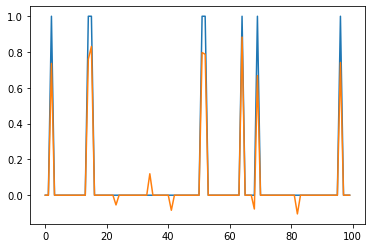

In [12]:
from matplotlib import pyplot as plt
plt.plot(x_true)
plt.plot(x_guess)

In [13]:
np.isin(x_true_nonzero, x_guess_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True]])

From what is directly above, we see clearly that all the nonzero entries inside our true solution $\verb+x_true+$ are at least inside the solution given by the lasso regression, $\verb+x_guess+$. Though, note that the number of nonzero entries in $\verb+x_guess+$ is greater than that of $\verb+x_true+$:

In [14]:
print("This is the number of nonzero entries in x_guess: " + str(len(x_guess_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in x_guess: 13
This is the number of nonzero entries in x_true: 8


Hence, there is imprecision in that we would prefer to have more entries in $\verb+x_guess+$ to be closer to 0.

We also show the number of iterations and the time it takes for the lasso method to converge:

In [15]:
print("This is the number of iterations required for lasso to converge: " + str(iters))
print("This is the number of seconds it takes for lasso to converge: " + str(end - start))

This is the number of iterations required for lasso to converge: 1785
This is the number of seconds it takes for lasso to converge: 0.08985209465026855


## Section 2 - SR3 method

We will compare the above to the SR3 method. For reference, the general SR3 formulation is as follows:
\begin{align*}
    \displaystyle \min_{x,w} \frac{1}{2}||Ax-b||^{2} + \lambda R(w) + \frac{\kappa}{2}||Cx - w||^{2}.
\end{align*}
We first want to recover a relaxed version of lasso. To do this, we take $R(\cdot) = ||\cdot ||_{1}$ and $C=I$. In this instance as well, we take $\kappa = 100$. We proceed as follows. 

In [16]:
C = np.eye(n,n)
kappa = 0.1
lam_sr3 = (lam/(1 + cond_A**2))*kappa

Central to the algorithm we implement is
\begin{align*}
    H_{\kappa} = A^{\top}A + \kappa C^{\top}C .
\end{align*}
We define this matrix immediately below.

In [17]:
H_k = np.dot(A.T,A) + kappa*np.dot(C.T,C)
H = np.linalg.inv(H_k)
w = np.ones(n)

We now implement the algorithm for SR3

In [18]:
k_sr3 = 0
eta = 1/kappa
max_step = 100

In [19]:
def sr3(w, H, A, b, C, max_step, k, eta, tol, kappa, lam):
    start = time.time()
    while (max_step > tol):
        k += 1
        w_old = w
        x = H@(np.dot(A.T, b) + kappa*np.dot(C.T, w_old))
        w = prox_op(np.dot(C,x),eta*lam)
        step = abs((w - w_old)/eta)
        max_step = step.max()
    end = time.time()
    return w, start, end, k

In [20]:
w_guess, start_sr3, end_sr3, iters_sr3 = sr3(w,H,A,b,C,max_step,k_sr3,eta,tol,kappa,lam_sr3)

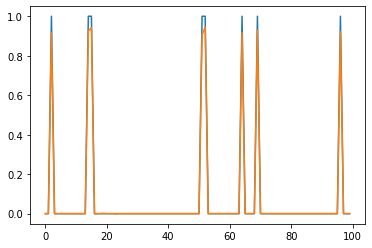

In [21]:
plt.plot(x_true)
plt.plot(w_guess)

In [22]:
w_guess_nonzero = np.nonzero(w_guess)
np.isin(x_true_nonzero, w_guess_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True]])

Clearly, $\verb+w_guess+$ contains nonzero entries in mostly the same places as does $\verb+x_true+$. Next, we look at how many nonzero entries there are in $\verb+w_guess+$.

In [23]:
print("This is the number of nonzero entries in w_guess: " + str(len(w_guess_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in w_guess: 11
This is the number of nonzero entries in x_true: 8


Note that, even though there are more nonzero entries in $\verb+w_guess+$ than in $\verb+x_true+$, the number of non-sparse entries is much closer than what was obtained using the standard lasso method, using all the same parameters. Thus, we have a higher level of precision, as we desired.

Last, we look at the number of iterations SR3 took to converge and the number of seconds required fro convergence.

In [24]:
print("This is the number of iterations required for SR3 to converge: " + str(iters_sr3))
print("This is the number of seconds it takes for SR3 to converge: " + str(end_sr3 - start_sr3))

This is the number of iterations required for SR3 to converge: 88
This is the number of seconds it takes for SR3 to converge: 0.00992584228515625


Note that, even for a small-dimension problem, the number of iterations required for SR3 to converge is decreased by an order of 10, as for the number of seconds required for convergence. This is exactly what we anticipated from the results shown in J33.

Use relationship between condition number of $A^{\top}A$ to get $\lambda$ parameter value for relaxed problem. It's how I define it using the variable $\verb+lam_sr3+$.

Next, we seek to deblur an image using SR3, implementing the FISTA algorithm.

## Section 3 - FISTA on non-image data

Before we do image deblurring, we're just going to run FISTA on the contrived data. So we reinitialize everything according to Section (1) again

In [127]:
cond_A = svdvals(A)[0]
eta = 0.001
k = 0
tol = 0.00001
max_step = 100
t = 1
L = np.linalg.eigvals(A.T@A)[0]
Linv = 1/L
assert eta <= 1/(cond_A**2)

In [123]:
def FISTA_norm(x, y, t, max_step, k, lam, tol):
    start = time.time()
    while (max_step > tol):
        k += 1
        x_old = x
        y_old = y
        t_old = t
        z = y_old - Linv*(A.T)@((A@y_old)-b)
        x = prox_op(z, lam*Linv)
        t = (1 + np.sqrt(1 + 4*t_old**2))/2
        y = x + ((t_old-1)/t)*(x - x_old)
        step = abs((y - y_old)*Linv)
        max_step = step.max()
    end = time.time()
    return y, start, end, k

In [128]:
y_fista, start, end, k_fista = FISTA_norm(x_init, x_init, t, max_step, k, lam, tol)

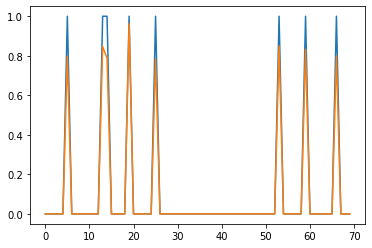

In [129]:
from matplotlib import pyplot as plt
plt.plot(x_true)
plt.plot(y_fista)

The results from the plot are encouraging since they tell us that our vanilla FISTA model running on just the contrived data seems to be working.

In [130]:
y_fista_nonzero = np.nonzero(y_fista)
x_true_nonzero = np.nonzero(x_true)
np.isin(x_true_nonzero, y_fista_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True]])

In [131]:
print("This is the number of nonzero entries in y_fista: " + str(len(y_fista_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in y_fista: 8
This is the number of nonzero entries in x_true: 8


In [132]:
print("This is the number of iterations required for FISTA to converge: " + str(k_fista))
print("This is the number of seconds it takes for FISTA to converge: " + str(end - start))

This is the number of iterations required for FISTA to converge: 31
This is the number of seconds it takes for FISTA to converge: 0.002595186233520508


I'm not really going to comment on any of this. Needless to say, FISTA is working about as well as we could hope.

## Section 4 - FISTA on image deblurring

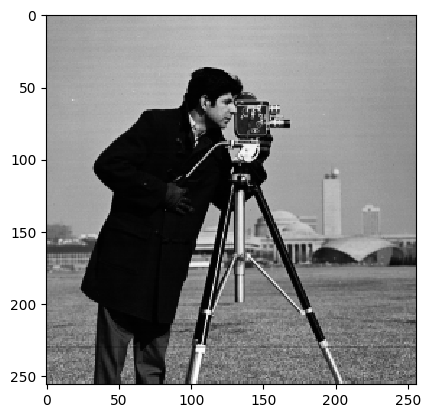

In [2]:
original = plt.imread("cameraman256.png")
plt.imshow(original,interpolation="nearest",cmap=plt.cm.gray)

In [3]:
m=original.shape[0]
n=original.shape[1]

We are now going to blur this image, following the details provided in the FISTA paper. To do this, we pass the image through a Gaussian blur of size $9 \times 9$ and standard deviation 4, which we follow by adding on a zero-mean white Gaussian noise with standard deviation $10^{-3}$.

To pass the image through the Gaussian blur, we first need to import a package from $\verb+scipy+$ and create a function on our own to approximate the $\verb+imfilter+$ and $\verb+fspecial+$ functions in $\verb+MATLAB+$.

Do adjoint test for 2d convolution operation (formula online). Look for code that already implements this.

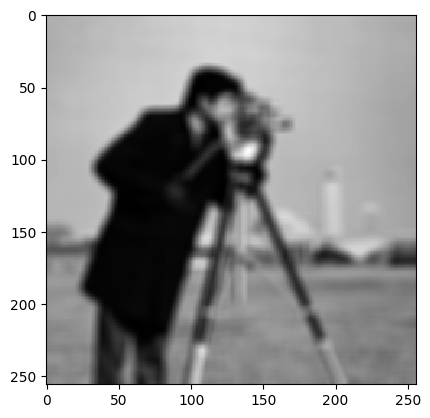

In [4]:
from operators import blur_operator_torch
blurred = blur_operator_torch(original)
plt.imshow(blurred.view(m,m),interpolation="nearest",cmap=plt.cm.gray)

As we can see, this successfully blurred the image as we desired. Now we look to construct the problem by first constructing our blur operator.

Is there a fast way to solve blur transpose blur: $R^\top R$. Yes, think about Woodbury matrix inversion. Look in book for case where A is actually spectrally diagonalizable (through Fourier transform matrices). Derive closed form solution in SR3 (look at pictures)

Here we will perform our adjoint test for the adjoint of the blur operator, as the correct adjoint for this method is necessary

In [6]:
from operator_tests import test_blur
test_blur(org, blurred,1e-1)

True

Here, we now perform the adjoint test for the adjoint of the wavelet operator, as we must check to see if our operator is being implemented correctly.

In [7]:
from operator_tests import test_wavelet
test_wavelet(org, blurred)

False

Here we now perform the adjoint test for the adjoint of the grad operator, since, if it passes, this will tell us if our operator has been implemented successfully.

In [6]:
# from operator_tests import test_grad
# test_grad(org,blurred)

Last, we perform the adjoint test for the adjoint of the proximal operator, in this case using the soft-thresholding function since we are using $l_1$ regularization.

In [9]:
from operator_tests import test_prox
lam = 0.001
test_prox(org,blurred,lam)

This test fails


(14628.962, 30.51236, 14598.449)

This is failing because the operator is not linear!

Do gradient test for the gradient (for general objective functions):

complex step method (look at pictures).

Here we take the discrete 2D cosine transform of the matrix $A^\top A$. Once we do this, we can use the formula
\begin{align*}
    \lambda_{i} = \frac{[Ca_1]_{i}}{c_{i1}}
\end{align*}
where $a_1$ is the first column of $A^\top A$ and $C$ is the resulting matrix from the discrete cosine transform. I get this information from the book Deblurring Images.

In [5]:
from operators import evals_blur, fspecial
L = evals_blur(fspecial((9,9),4))[0]*2
Linv = 1/L
k_FISTA = 0
max_iter = 200

Now we are going to define our first guesses and reshape all of our data.

In [6]:
b = blurred
x_init = torch.ones(m**2)
y0 = x_init.clone()
t = 1
lam = 2e-5

Since we also need the gradient of
\begin{align*}
    f(x) = ||Ax-b||^{2}
\end{align*}
which is
\begin{align*}
    \nabla f(x) = 2A^{\top}(Ax-b)
\end{align*}
we define a quick anonymous function to do the calculations for us

In [7]:
from operators import grad, gen_function, grad_check
smt = grad(y0,b,gen_function)

In [8]:
from operators import grad, wavelet_op1d_torch, prox_op, prox_op_torch, wavelet_inverse_torch, blur_operator, gen_function

In [9]:
x = x_init
y = y0
start = time.time()
step_size_list = []
function_values = []
while (k_FISTA <= max_iter):
    k_FISTA += 1
    x_old = x
    y_old = y
    t_old = t
    grd = grad(y_old, b, gen_function)
    with torch.no_grad():
        z = y_old - Linv*grd
        c = wavelet_op1d_torch(z)
        d = prox_op_torch(c[0],lam/Linv)
        x = wavelet_inverse_torch(d,c[1])
        t = 0.5*(1 + np.sqrt(1 + 4*t_old**2))
        y = x + (t_old/t)*(x - x_old)
        # y = x
        step = abs((y-y_old)/Linv)
        max_step = torch.max(step)
        step_size_list.append(max_step)
        function_values.append((gen_function(y,b) + lam*np.linalg.norm(c[0], ord=1)))
    y_old.grad.zero_()
end = time.time()

In [8]:
from optimization_algs import FISTA
y, start, end, step_sizes, function_values, k_FISTA = FISTA(x_init, y0, b, t, k_FISTA, max_iter, lam, Linv)

ValueError: too many values to unpack (expected 5)

List:
1. Operators - Figure out how to get adjoint codes for operators work -> make adjoint test a unit test.
2. Abstract the algorithms to take prox's and grad's, and then build the pieces to fit into equation.
3. Include unit tests for gradient and prox.
4. Store information for both PG and FISTA on function value and step size (defined above)
5. Run prox gradient on deblurring problem.
6. Do SR3 and in so doing make everything agnostic inside the optimzation algorithms

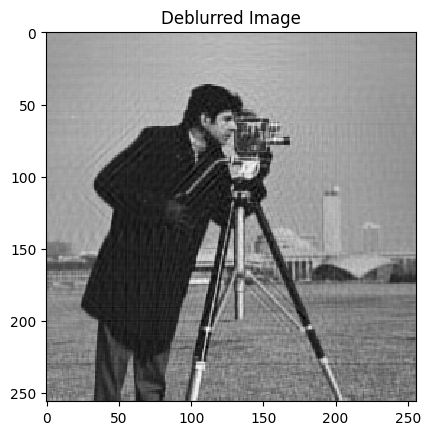

In [10]:
from plotting import FISTA_plot
FISTA_plot(y,m)

Text(0.5, 1.0, 'Function Value plot')

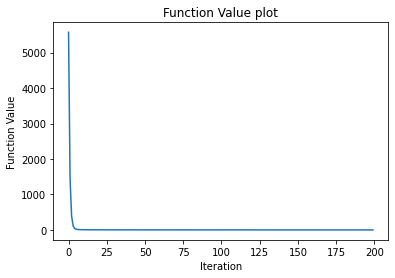

In [14]:
from plotting import function_vals_plot
function_vals_plot(max_iter, function_values)
plt.title("Function Value plot")

Text(0.5, 1.0, 'Step Size plot')

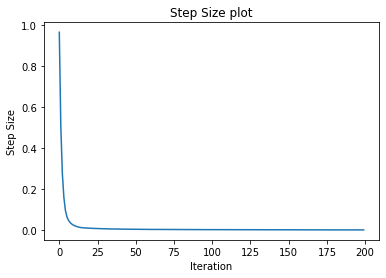

In [15]:
from plotting import step_size_plot
step_size_plot(max_iter, step_sizes)
plt.title("Step Size plot")

In [17]:
print("The step size at iteration 1 is " + str(step_sizes[0]))
print("The step size at iteration 100 is " + str(step_sizes[99]))
print("The step size at iteration 200 is " + str(step_sizes[199]))

The step size at iteration 1 is 1.5600878668569345
The step size at iteration 100 is 0.010268842564357339
The step size at iteration 200 is 0.00535512093071637


## Section 5 - SR3 with FISTA for image deblurring

In [18]:
k_FISTA = 0
max_iter = 200
kappa = 0.25

In [7]:
import torch

In [32]:
x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5,3, requires_grad=True)
b = torch.randn(3, requires_grad=True)

In [38]:
fcn = torch.matmul(x,w) + b
loss = torch.nn.MSELoss()
output = loss(y,fcn)

In [39]:
output.backward()
w.grad

tensor([[-0.2545, -1.6967, -1.8885],
        [-0.2545, -1.6967, -1.8885],
        [-0.2545, -1.6967, -1.8885],
        [-0.2545, -1.6967, -1.8885],
        [-0.2545, -1.6967, -1.8885]])

In [24]:
fcn

tensor([-2.9872, -3.2562, -3.5938], grad_fn=<AddBackward0>)

In [27]:
fcn.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

In [23]:
w.grad

tensor([[0.0160, 0.0124, 0.0089],
        [0.0160, 0.0124, 0.0089],
        [0.0160, 0.0124, 0.0089],
        [0.0160, 0.0124, 0.0089],
        [0.0160, 0.0124, 0.0089]])

In [28]:
def your_function(x):
    return x**3 + 2*x**2 + 5*x + 7

# Create a tensor with requires_grad=True
x = torch.tensor(2.0, requires_grad=True)

# Evaluate the function
y = your_function(x)

# Perform automatic differentiation
y.backward()

In [30]:
x.grad

tensor(25.)

In [5]:
type(torch.norm(torch.Tensor([1,2])))

torch.Tensor

In [42]:
(1**2 + 2**2)**(1/2)

2.23606797749979

In [8]:
a = torch.norm(torch.Tensor([1,2]))

In [9]:
a.numpy()

AttributeError: 'Tensor' object has no attribute 'numpy_'

In [17]:
from operators import fspecial
from scipy.ndimage import correlate
org = torch.ones(n**2)
reshape = True
if reshape:
    m = int(np.sqrt(org.size(0)))
    # org = np.reshape(org, (m,m), order="F")
    org = org.view(m,m)

psf = fspecial((9,9),4)
blurred = correlate(org, psf, mode="reflect")
# blurred += np.random.normal(0,1e-4,size=(m,m)) #TODO: Add this separately
blurred = blurred.T
if reshape:
    blurred = blurred.flatten("F")

torch.from_numpy(blurred)

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [24]:
org_tensor = torch.rand(5,5)
org_tensor.size()

torch.Size([5, 5])

In [26]:
org_tensor.unsqueeze(0).size()

torch.Size([1, 5, 5])

In [6]:
a = np.arange(1,6)
v = np.arange(6,8)

In [7]:
a

array([1, 2, 3, 4, 5])

In [8]:
v

array([6, 7])

In [16]:
x = torch.Tensor(a).unsqueeze(0).unsqueeze(0)
w = torch.Tensor(v).unsqueeze(0).unsqueeze(0)

In [17]:
torch.nn.functional.conv1d(x,w)

tensor([[[20., 33., 46., 59.]]])

In [7]:
len(torch.ones(50,10).size())

2